# Molecular Dynamics Simulation for Argon

In this project we want to simulate an Argon gas. First, we initalize the system consisting of N atoms. Then, we will calculate the interactions between the particles for succesive timesteps to simulate the behaviour of the gas in time. Furhtermore we will assume periodic boundary conditions.
A large part of the code is dedicated to extract physical quantities from the produced data

In [1]:
import numpy as np
import cProfile
import profile
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
import json

In [2]:
#This block is needed to create homogeneous plots throughout the project
fparams = {'axes.labelsize': 22,
           'axes.titlesize': 25,
           'axes.linewidth': 1.5,
           'font.size': 16,
           'legend.fontsize': 20,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 15,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.5,
           'ytick.labelsize': 15,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.5,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(fparams)

Assign values to parameters (we use natural units):

In [3]:
kb = 1          # Natural Unit
T = 1           # Unit: epsilon/kb (120)
eps = 1         # Natural unit of energy, depth of the potential well
sig = 1         # Natural unit of length, width of the potential well
mass = 1        # Natural unit of mass,   mass of of argon atom
rmin=sig*2**(2/3) #length unit cell s.t. atoms are in minima of LJ potential

a = rmin*1.2           # Set length unit cell
r_cutoff = (sig*3)     #cutoff distance in force calculation
r_cutoff2 = r_cutoff   #squared cutoff distance

def set_num_particle(unit_cell_per_direction,a):
    """Set number of unit cells, and in doing so, the number of particles"""
    m= unit_cell_per_direction
    L=m*a                      # size of system
    Nunit=m**3                 # number of unit cells
    N=4*Nunit                  # number of atoms
    return m, N, L

def set_density(density):
    a = rmin*density**(-1/3)
    return a

dt=.004         #In natural units
tsteps = 2000   

## Initial Velocities

Let us now write a function to initialize the velocities. The velocity matrix v has 3 x N components. Each particle has three components: the first one is in the x direction, the second in y and the third in z. 
First we draw the velocities according to the Maxwell-Boltzmann distribution: a gaussian distribution in each direction. Then we make sure that the total momentum (and thus velocity) in each direction in zero, by substracting the average velocity in each direction. Then we rescale the velocity such that we statisfy the equipartition theorem.

In [4]:
def initialize_velocity(N,T):
    #We draw 3N velocity components from Gaussian Distribution
    v = np.random.normal(0,(T)**(1/2),(3,N))

    #The average velocity is substracted so that the total momentum is zero in each direction.
    v += -np.transpose(np.ones((N,1))*np.sum(v,1)/N)

    #We now rescale velocity
    v = v*(np.sum(v*v)/(3*(N-1)*T))**(-1/2)
    return v

## Initial positions

Now we write a function to initialize the position vector x, which also is a (3,N) matrix. We start of with an FCC lattice.
In FCC atoms are located at (0,0,0), (0,a/2,a/2), (a/2,a/2,0) and (a/2,0,a/2).
As we have m unit cells in each direction, we concatenate m x m x m unit cells.
The graph illustrates the intial positions.

In [5]:
def initialize_position(N,a):
    """Given the number of Atoms N, and the lattice size a, this function returns
    initial positions in FCC latice"""
    x=np.zeros((3,N))
    p=0
    for i in range(m):
        for j in range(m):
            for k in range(m):
                x[:,p]+=[i*a, j*a, k*a]
                x[:,p+1]=[i*a+a/2, j*a+a/2, k*a]
                x[:,p+2]=[i*a, j*a+a/2, k*a+a/2]
                x[:,p+3]=[i*a+a/2, j*a, k*a+a/2]
                p=p+4
    
    return x

## Force Function

The function Force_vector_potenial loops over all posible particle pairs. Then it calculates if they are within a treshold range. If they are closer than r_cutoff then we calculate the force and potential caused by this interation. The Numba command @jit is used to speed up this calculation. Numba prefers simple calculations, thus multiplication is used as often as possible. Furthermore rint is much faster wihtin Numba than np.round, thus rint is used.

In [6]:
@jit
def force_vector_potential(pos_vector,N,L,pressure = False):
    """Given the position vector, calculate the total force on each particle and 
    total potenial energy"""
    N = np.shape(pos_vector)[1]
    Fx = np.zeros(N)
    Fy = np.zeros(N)
    Fz = np.zeros(N)
    Pot = 0
    Pvirial = 0
    for i in range(N):
        for j in range(i):
            dx = pos_vector[0,j] - pos_vector[0,i] 
            dx -= np.rint(dx/L)*L
            dy = pos_vector[1,j] - pos_vector[1,i] 
            dy -= np.rint(dy/L)*L
            dz = pos_vector[2,j] - pos_vector[2,i] 
            dz -= np.rint(dz/L)*L
            magdr2 = dx*dx + dy*dy + dz*dz
            
            if (magdr2 < r_cutoff2):
                dr2i = 1/magdr2
                dr6i = dr2i*dr2i*dr2i
                Fji = 4*dr6i*dr2i*(12*dr6i-6)

                Pot += 4*dr6i*(dr6i-1)

                Fx[i] -= Fji*dx #Force on i is minus force on j.
                Fx[j] += Fji*dx
                Fy[i] -= Fji*dy
                Fy[j] += Fji*dy
                Fz[i] -= Fji*dz 
                Fz[j] += Fji*dz
                if pressure:
                    Pvirial += Fji*magdr2   #- Force on i
                    
    return np.array([Fx,Fy,Fz]), Pot, Pvirial

## The Simulation Function 

The simulate functions returns the final positions and velocities, when you input the initial positions and velocities. In order for this function to work, we have global variables: tsteps (number of time steps) and $\Delta$t, length one timestep, N (number of particles)

In [7]:
def simulate(x_init, v_init,N,L,T, step_equi = 500, rescale = False, energycheck 
             = False, pressure = False, heat_capacity = False, diffusion = False):
    """Simulate the system starting from the given inital conditions, options
    to extract physical quantities"""
   
    #Initialize forces
    Force = force_vector_potential(x_init,N,L)[0]
    x_temp = x_init
    v_temp = v_init
    
    if energycheck:    
        print('momentum in each direction start: ',calculate_momenta(v_temp))
    
    V = np.zeros(tsteps)        #To store potential energy 
    Pvirial = np.zeros(tsteps)  #To store part of the pressure calculation
    K = np.zeros(tsteps)        #To store kinetic Energy
    count = 0
    mean_displacement = np.zeros(tsteps)   #To store mean displacement, diffusion
    x_displ = np.zeros((3,N))
    
    for t in range(tsteps):
        
        #Update the position vector and correct for boundary
        x_temp += v_temp*dt + Force*.5 * dt*dt
        x_temp = x_temp%L
        
        #In addition we keep a list where we do not correct 
        if diffusion:
            x_displ += v_temp*dt + Force*.5 * dt*dt
            
            #mean squared displacement:
            mean_displacement[t] = np.mean(np.sum(np.multiply(x_displ, x_displ), 
                                                  axis = 0))
        
        #Add the old force to the velocity
        v_temp += dt*.5 * Force
        
        #Calculate the new force
        Force,V[t],Pvirial[t] = force_vector_potential(x_temp,N,L,pressure)
        
        #And then add the new force to the velocity
        v_temp += dt*.5 * (Force)
        
        if energycheck:
            #Calculate kinetic energy
            K[t] = calculate_kinetic(v_temp)
            if (K[t] > 1e15) and (count < 4):
                indices = np.triu_indices(N,1)
                dis = x_temp[:,indices[0]] - x_temp[:,indices[1]]
                dis -= np.rint((dis)/L)*L      #Keep atoms within box
                dis2 = np.sum(dis*dis,axis=0)
                count += 1
         
        #In order to calculate heat capacity, we need to keep track of the 
        #kinetic energy
        if heat_capacity:
            K[t] = calculate_kinetic(v_temp)
            
        #Rescale temperature if required
        if  (rescale & (t < step_equi) & (t%20 == 0)):
            v_temp=v_temp*(np.sum(v_temp*v_temp)/(3*(N-1)*T))**(-1/2)
        
            
    if energycheck:
        plt.figure()
        plt.plot(range(tsteps),V)
        plt.plot(range(tsteps),K)
        plt.plot(range(tsteps),V+K)
        print('momentum in each direaction end: ',calculate_momenta(v_temp))
        
    if pressure: 
        return x_temp, v_temp, Pvirial
    
    if heat_capacity:
        return x_temp, v_temp, K
    
    if diffusion: 
        return x_temp, v_temp, mean_displacement
    
    return x_temp, v_temp

In [8]:
def plot_position(pos_vector):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos_vector[0,:],pos_vector[1,:],pos_vector[2,:])
    ax.set_xlim3d([0,L])
    ax.set_ylim3d([0,L])
    ax.set_zlim3d([0,L])
    
def plot_velocity(vel_vector):
    velocities = np.linalg.norm(vel_vector, axis = 0)
    fig = plt.figure()
    plt.hist(velocities)

## Datablocking

In [9]:
def data_blocking(datavector, l, stdvar = False):
    """This function calculates the average and standard deviation 
    of the physical input data, using data_blocking with blocks of length l"""
    
    #Divide the datavector in blocks
    blocks = [datavector[i:i+l] for i in range(0, len(datavector), l)]
    
    #Remove the last block (with probably different length)
    blocks = blocks[:-1] 
    
    mean_array = [np.mean(A) for A in blocks]
    mean_sqd = [A**2 for A in mean_array]
    mean = np.mean(mean_array)
    
    std = np.sqrt(np.mean(mean_sqd) - mean**2)
    
    #For heat capacity, we the variance of the <\delta K^2>
    delta_array = [np.var(A) for A in blocks]
    stdvar = np.std(delta_array)

    if stdvar: 
        return mean, std, stdvar
    
    return mean, std

In [10]:
def data_blocking_Cv(kin_ener_vector, l, N):
    """This function calculates the average and standard deviation 
    of the physical input data, using data_blocking with blocks of length l"""
    
    #Divide the datavector in blocks
    blocks = [kin_ener_vector[i:i+l] for i in range(0, len(kin_ener_vector), l)]
    
    #Remove the last block (with probably different length)
    blocks = blocks[:-1] 
    
    deltaK2_ar = [np.var(A) for A in blocks]
    kin_ar2 = [np.mean([x**2 for x in A]) for A in blocks]
    
    
    Cv_array = [(-deltaK2_ar[x]/kin_ar2[x] + 2/(3*N))**(-1)/N for x in range(len(deltaK2_ar))]
    
    mean = np.mean(Cv_array)
    
    std = np.std(Cv_array)
    
    return mean, std

## Calculate energies and momenta

In [11]:
def calculate_kinetic(velocity_vector):
    """Given the velocity matrix, calculate the kinetic energy"""
    return .5*np.sum(velocity_vector*velocity_vector)

def calculate_momenta(velocity_vector):
    """Given the velocity matrix, calculate momentum in each direction"""
    return np.sum(velocity_vector,axis=1)

## Calculate correlation function

In [12]:
def plot_correlation_function(pos_vector):
    indices = np.triu_indices(N,1)
    dis = pos_vector[:,indices[0]] - pos_vector[:,indices[1]]
    dis -= np.round((dis)/L)*L
    disnorm = np.linalg.norm(dis,axis=0)
    histo=np.histogram(disnorm,bins=30,range=[0, L*.5])
    fig = plt.figure()
    
    plt.plot(histo[1][1:len(histo[0])+1],histo[0]/(histo[1][1:len(histo[0])+1]**2))


## Calculating Correlation Function 

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000


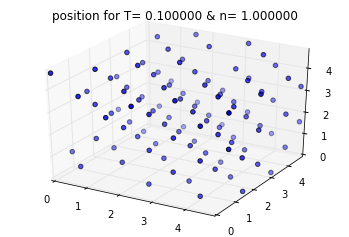

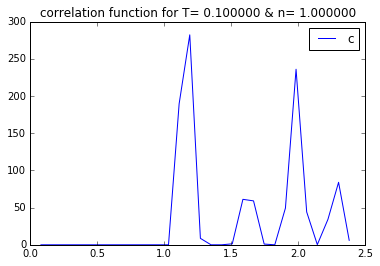

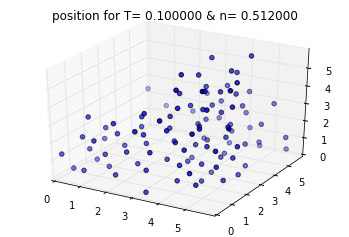

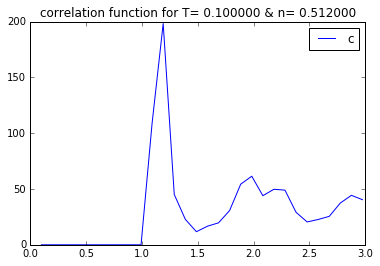

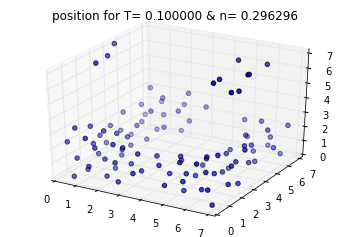

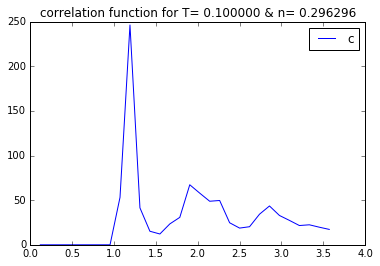

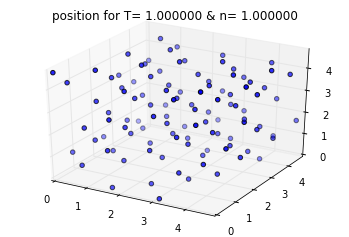

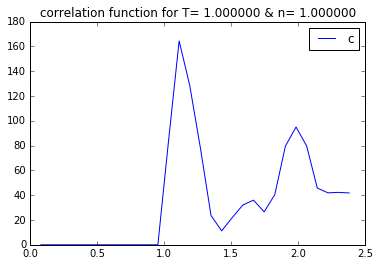

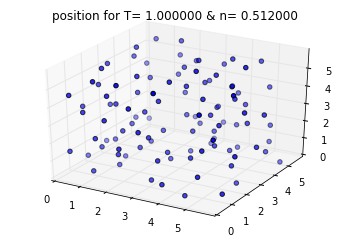

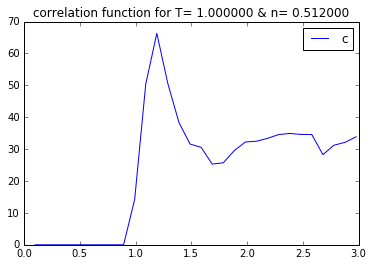

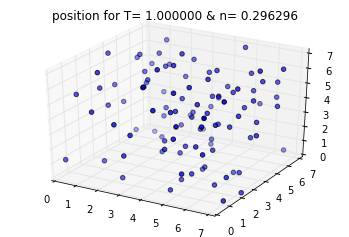

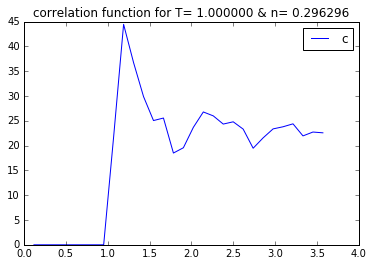

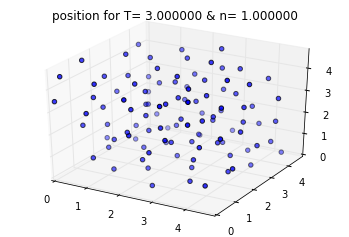

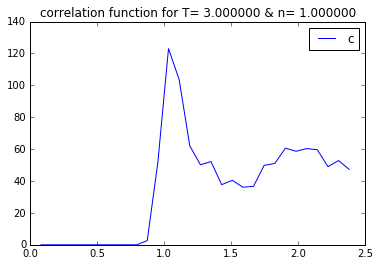

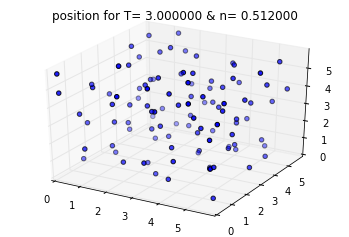

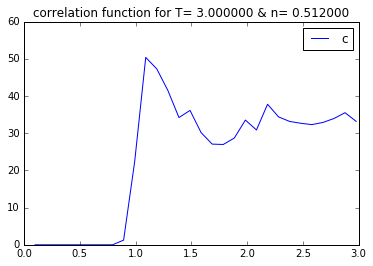

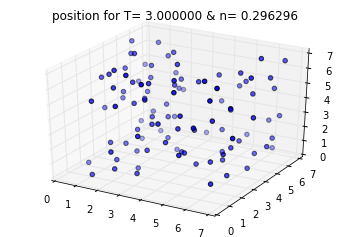

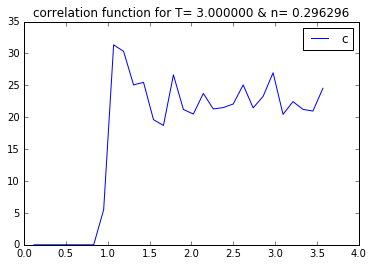

In [263]:
Tarray = [0.5, 1, 3]
narray = [1.2,.8, .3]
a =1 #only needed to set N
m, N, L = set_num_particle(6,a)
xfinal=np.zeros([len(Tarray),3,N])
for i in range(len(Tarray)):
        T=Tarray[i]
        a =set_density(narray[i])
        m, N, L = set_num_particle(6,a)
        v_init = initialize_velocity(N,T)
        x_init = initialize_position(N,a)
        xfinal[i,:,:],v=simulate(x_init,v_init,N,L,T,rescale=True)

In [ ]:
fig = plt.figure()
for i in range(len(Tarray)):
    plot_correlation_function(xfinal[i,:,:])
    
plt.title(r'Pair correlation function $g(r)$', fontweight = 'bold')
plt.xlabel(r'$r (\sigma)$', fontweight = 'bold')
plt.ylabel(r'$g$', fontweight = 'bold')
plt.legend(['Solid', 'Liquid', 'Gas'], loc = 1)
plt.xlim([0,3])
#plt.savefig(".\img\Results\CorrelationFunction\CorrelationFunction.pdf")

## Pressure versus density for different T

We are going to calculate the pressure using the Virial Theorem:

$P = \frac{Nk_bT}{V}\left[1 - \frac{1}{3Nk_bT}\langle\sum_{i}\frac{\partial U}{\partial\boldsymbol{r}_i}\cdot\boldsymbol{r_i}\rangle\right]$

Since potential is built up by two particle interactions, we can easily calculate $\langle\sum_{i}\frac{\partial U}{\partial\boldsymbol{r}_i}\cdot\boldsymbol{r_i}\rangle$ as sum over the forces which we calculate. 

However the particles which are further than $r_{cutoff}$ apart, also give a significant contribution!

Now look at equation 8.19 in Book. 
$$\frac{P}{nk_bT} = 1 - \frac{1}{3Nk_bT}\langle\sum_{i}\sum_{j \geq i}r_{ij}\frac{\partial U(R)}{\partial{r_{ij}}} \rangle_{cutoff} - \frac{2\pi N}{3k_bTV}\int_{r_{cut-off}}^{\infty}r^3\frac{\partial U(r)}{\partial{r}}g(r)~\mathrm{d}r$$

We therefore calculate: $\int_{r > r_{cutoff}}rg(r) \frac{\partial U}{\partial r} d^3\boldsymbol{r}$ analytically, by assuming $g(r) \approx 1$ for $r > r_{cutoff}$

This gives: $\int_{r > r_{cutoff}}rg(r) \frac{\partial U}{\partial r} d^3\boldsymbol{r} \approx 32\pi\frac{1}{r_{cutoff}^3}$

The total contribution will therefore be: 
$\frac{N}{6k_bTV}32\pi\frac{1}{r_{cutoff}^3}$

NOTE THAT WE HAVE TO KEEP T FIXED, USE RESCALE
AND SOMEHOW OUR VIRIAL PART HAS A MINUS WRONG. FIND OUT WHY (WE NOW USE A PLUS IN THE Pformula SHOULD BE A MINUS

In [42]:
#For the temperatures in T_array, we will plot pressure
T_array = [1, 1.35, 2.74]

#Choose which density values are used for each temperature value
narray = [np.linspace(0.65, 0.9, 5), np.linspace(0.2, 0.9, 20), 
          np.linspace(0.2, 0.8,20)]

#Create arrays to save beta*times pressure value and the error
zero_array = [np.zeros(len(narray[0])), np.zeros(len(narray[1])), 
              np.zeros(len(narray[2]))]
betaParray,error_array = zero_array, zero_array

#We must make sure that the systems comes to equilibrium
step_equi = 2000
tsteps = 4000
countT = 0

for Temp in T_array:
    count = 0
    
    for n in narray[countT]:
        a = set_density(n)
        m, N, L = set_num_particle(6,a)
        
        v_init = initialize_velocity(N,Temp)
        x_init = initialize_position(N,a)
        
        x, v, P_virial = simulate(x_init,v_init,N,L,Temp,rescale=True, 
                                  pressure = True)
        P_virial_contr = (3 * N * kb * Temp)**(-1) * P_virial
        
        #Now the analytic part
        Pvirial_analytic = N/(6 * kb * Temp * L**3 * r_cutoff**3) * 32 \
                          * np.pi*np.ones(tsteps)
        
        #After analytic part we have the pressure for all times t
        P = N * kb * Temp * L**(-3) * (1 + P_virial_contr - Pvirial_analytic)

        #Calculate the average and the std (for the error), after
        #equilibrium is reached
        P_average, err = data_blocking(P[step_equi:], 80)
        
        print(count, end = " ")
        betaParray[countT][count] = 1/Temp * P_average
        error_array[countT][count] = err
        count += 1
    countT += 1
    
#Write the essential information to data files
np.save('.\Data\Pressure\pressure_2ndtry', betaParray)
np.save('.\Data\Pressure\pressure_n_2ndtry', narray)
np.save('.\Data\Pressure\pressure_error_2ndtry', error_array)
np.save('.\Data\Pressure\pressure_param_2ndtry', T_array)

0 1 2 3 4 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

C:\Users\TU Delf SID\Anaconda3\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


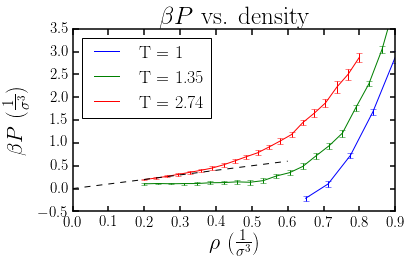

In [45]:
#We now make the figure where we plot \Beta*Pressure vs density
#We want A larger legend fontsize for this plot
p_store =fparams['legend.fontsize']
fparams['legend.fontsize'] = 18
plt.rcParams.update(fparams)

#Read required data from the file
betaParray = np.load('.\Data\Pressure\pressure.npy')
narray = np.load('.\Data\Pressure\pressure_n.npy')
error_array = np.load('.\Data\Pressure\pressure_error.npy')
n_clas = np.linspace(0,0.6, 1000)

#Make plot with errorbars and save it
plt.errorbar(narray[0], betaParray[0], yerr = error_array[0])
plt.errorbar(narray[1], betaParray[1], yerr = error_array[1])
plt.errorbar(narray[2], betaParray[2], yerr = error_array[2])

#Plot classical expectation
p_clas = [rho for rho in n_clas]
plt.plot(n_clas, p_clas, 'k--')

#plot pressure
plt.plot()
plt.title(r'$\beta P$ vs. density', fontweight = 'bold')
plt.xlabel(r'$\rho$  $(\frac{1}{\sigma^3})$', fontweight = 'bold')
plt.ylabel(r'$\beta P$  $(\frac{1}{\sigma^3})$', fontweight = 'bold')
plt.legend(['T = 1', 'T = 1.35', 'T = 2.74'], loc = 2)
plt.ylim([-0.5,3.5])
plt.xlim([0,0.9])
plt.savefig("./Verslag/img/Results/Pressure/pressure.pdf")

#reset the legend font size to original value
fparams['legend.fontsize'] = p_store
plt.rcParams.update(fparams)

## Heat Capacity: 

Lebowitz: $\frac{\langle \delta K^2\rangle}{\langle K\rangle^2} = \frac{2}{3N}\left(1 - \frac{3N}{2C_v}\right)$

Note: $\langle \delta K^2\rangle$ means $\langle \Delta K\rangle^2$

$C_v = \left[-\frac{\langle \delta K^2\rangle}{\langle K\rangle^2} + \frac{2}{3N}\right]^{-1}$

In [24]:
T_array = np.concatenate((np.array([0.5,1]), np.linspace(2,12,6)))
n_array = np.array([1, 0.7, 0.2])
init_zero = np.zeros((len(n_array),len(T_array)))
T_finalarray = init_zero
Cv_array = init_zero 
Cv_array_1 = init_zero 
Error_array = np.zeros((len(n_array),len(T_array),2)) 
Error_array1 = init_zero 
ncount = 0    

for n in n_array:
           
    a = set_density(n)
    m, N, L = set_num_particle(5,a)
    
    count = 0
    for Temp in T_array:
        v_init = initialize_velocity(N,Temp)
        x_init = initialize_position(N,a)
        step_eq = 2000
        tsteps = 12500
        
        if Temp <= 1:
            step_eq = 5000
            tsteps = 20000
        

        x, v, kinetic_E = simulate(x_init,v_init,N,L,Temp, step_equi = step_eq,
                                   rescale = True, heat_capacity = True)

        T_final = np.mean(kinetic_E[(step_eq - tsteps):]*2)/(3*N) 
        DeltaK2_exp = np.var(kinetic_E[step_eq:])
        kinetic_E_exp, eps2, eps1 = data_blocking(kinetic_E[step_eq:], 1500, 
                                                    stdvar=True)

        eps2 = 2*kinetic_E_exp*np.sqrt(DeltaK2_exp)
        
        #Calculate Cv with formula, Error with our method
        C_v = (-DeltaK2_exp/(kinetic_E_exp**2) + 2/(3*N))**(-1)/N
        Cv_array[ncount, count] = C_v
        T_finalarray[ncount, count] = T_final

        E1 = N*C_v**2*1/(kinetic_E_exp**2)*eps1
        E2 = N*C_v**2*DeltaK2_exp/(kinetic_E_exp**4)*eps2
        Error1 = np.sqrt(E1**2 + E2**2)
        Error2 = abs(E1) + abs(E2)
        Error_array[ncount,count,:] = [Error1,Error2]
        
        #Calculate Cv + error using datablocking
        Cv_array_1[ncount, count], Error_array1[ncount,count] = data_blocking_Cv(kinetic_E[step_eq:], 1500, N)
        count += 1
        print (count, end = ' ')
    
    ncount += 1
    
    
np.save('.\Data\HeatCapacity\Cv_data2', Cv_array_1)
np.save('.\Data\HeatCapacity\Cv_own2', Cv_array)
np.save('.\Data\HeatCapacity\T_final2', T_finalarray)
np.save('.\Data\HeatCapacity\Errordata2', Error_array1)
np.save('.\Data\HeatCapacity\Error_own2', Error_array)
np.save('.\Data\HeatCapacity\pressure_array2', n_array)

1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 

C:\Users\Bas\Anaconda3\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


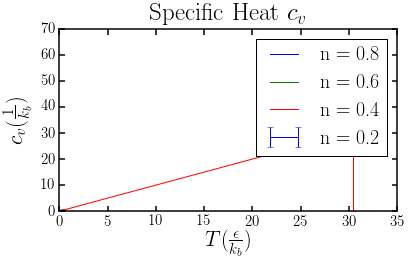

In [27]:
#Load Data   
cv_data = np.load('.\Data\HeatCapacity\Cv_data2.npy')
cv_dataown = np.load('.\Data\HeatCapacity\Cv_own2.npy')
T_final_array = np.load('.\Data\HeatCapacity\T_final2.npy')
error_data = np.load('.\Data\HeatCapacity\Errordata2.npy')
error_own = np.load('.\Data\HeatCapacity\Error_own2.npy')

plt.figure()
plt.errorbar(T_final_array[0,:], cv_data[0,:], yerr = error_data[0,:])
for i in range(2):
    plt.errorbar(T_final_array[i+1,:-2], cv_data[i+1,:-2], yerr = error_data[i+1,:-2])

plt.legend(['n = 0.8', 'n = 0.6', 'n = 0.4', 'n = 0.2'])
#plt.ylim([1.5,3.5])
plt.title(r'Specific Heat $c_v $', fontweight = 'bold')
plt.xlabel(r'$T (\frac{\epsilon}{k_b})$', fontweight = 'bold')
plt.ylabel(r'$c_v (\frac{1}{k_b})$', fontweight = 'bold')
plt.savefig("./Verslag/img/Results/HeatCapacity/secondtry.pdf")

## Diffusion!

In order to look at diffusion, we need the mean (over all particles) displacement of the initial position at different times t. 
We adjust our simulate function, to keep track of this displacement.
However, we have to be very careful with particles leaving the box and appearing on the other side! This would give huge displacement steps. 

[[ 0.00010856 -0.00010856]
 [-0.00010856  0.0001449 ]]
D is 1.97365730822
[[ 0.00224788 -0.00224788]
 [-0.00224788  0.00300017]]
D is 4.68037053528
D is 4.68037053528


C:\Users\TU Delf SID\Anaconda3\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


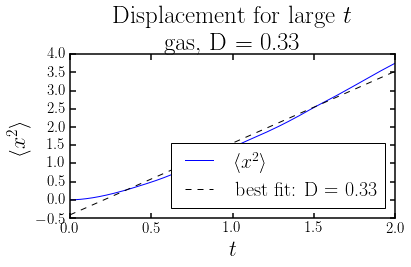

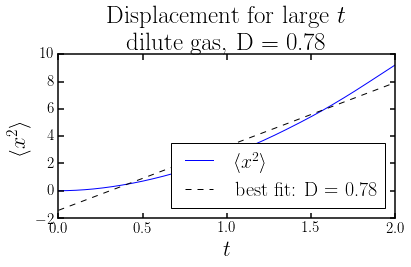

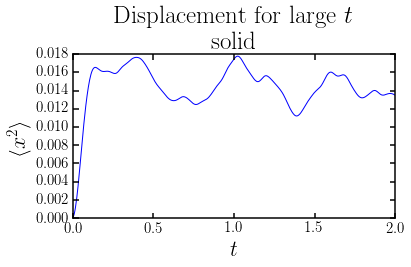

In [14]:
T_array = [3, 3, 0.5]
n_array = [0.3, 0.05, 1.2]
states = ['gas', 'dilute gas', 'solid']
total = 1000
free_time_array = np.zeros(len(T_array))

#We have to let the system come to equilibrium
step_equi = 500
tsteps = step_equi

times = np.linspace(0,dt*(total - step_equi),total - step_equi)
           
for i in range(len(T_array)):
    #Initialization
    n = n_array[i]
    a = set_density(n)
    Temp = T_array[i]
    m,N,L = set_num_particle(4,a)
    v_init = initialize_velocity(N,T)
    x_init = initialize_position(N,a)

    #Calculate the system after equilibrium
    x_equi, v_equi = simulate(x_init,v_init,N,L,T, rescale=True)
    v_mean = np.sqrt(3)*np.mean(3*abs(v_equi[0,:]**2))
    mean_free_time = a/(np.sqrt(2)*v_mean)
    free_time_array[i] = mean_free_time
    
    #Now we let the system run and 'diffuse'
    tsteps = total - step_equi
    x, v, x_displ = simulate(x_equi, v_equi, N,L,Temp, diffusion = True)
    
    #Plot the results
    plt.figure()
    plt.plot(times, x_displ)
    plt.title("Displacement for large $t$ \n {0} ".format(states[i]), 
              fontweight = 'bold')
    
    if i != 2:
        fit, CP =np.polyfit(times,x_displ,1, cov = True)
        print(CP)
        plt.plot(times, [fit[1] + fit[0]*t for t in times], 'k--')
        plt.legend([r'$\langle x^2 \rangle$', "best fit: D = {:02.2f}".format(fit[0]/6)], loc = 4)
        plt.title("Displacement for large $t$ \n {:s}, D = {:02.2f}".format(states[i], fit[0]/6), 
              fontweight = 'bold')
    print('D is', fit[0])
    plt.xlabel('$t$', fontweight = 'bold')
    plt.ylabel(r'$\langle x^2 \rangle $', fontweight = 'bold')
    
    #plt.savefig("./Verslag/img/Results/Diffusion/long_t{:02.2f}_{:02.2f}.pdf".format(n,Temp))
    
#Save mean_free_times
#np.save('.\Data\Diffusion\', mean_free_times)

 n = 0.5
a = set_density(n)
dt = 0.004
m, N, L = set_num_particle(4,a)
x_init = initialize_position(N,a)
v_init = initialize_velocity(N,T)
plot_position(x_init)

x, v = simulate(x_init,v_init,N,L,T)

plot_position(x)


## Testing shit